In [1]:
import os
import sys
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
# path
base_dir = 'D:/Documents/Code and Data/Data/Jute_Pest_Dataset/'

# # Define transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images
#     transforms.ToTensor(),          # Convert images to tensors
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize
# ])

# Transforms with data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load datasets
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_data = datasets.ImageFolder(root=train_dir, transform=transform)
val_data = datasets.ImageFolder(root=val_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Access the labels and class indices
print("Class Indices:", train_data.class_to_idx) 

Class Indices: {'Beet Armyworm': 0, 'Black Hairy': 1, 'Cutworm': 2, 'Field Cricket': 3, 'Jute Aphid': 4, 'Jute Hairy': 5, 'Jute Red Mite': 6, 'Jute Semilooper': 7, 'Jute Stem Girdler': 8, 'Jute Stem Weevil': 9, 'Leaf Beetle': 10, 'Mealybug': 11, 'Pod Borer': 12, 'Scopula Emissaria': 13, 'Termite': 14, 'Termite odontotermes (Rambur)': 15, 'Yellow Mite': 16}


In [3]:
def show_image(img, label, classes):
    # Undo normalization for visualization
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title(f"Label: {classes[label]}")
    plt.axis("off")
    plt.show()

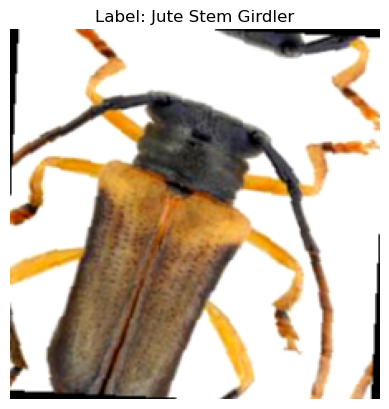

torch.Size([3, 224, 224])


In [4]:
# Select a random sample from the training dataset
classes = train_data.classes  # Class names
random_index = random.randint(0, len(train_data) - 1)
sample_image, sample_label = train_data[random_index]

# Visualize the image
show_image(sample_image, sample_label, classes)

# print image size
print(sample_image.shape)

## Custom CNN

In [5]:
class PestClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(PestClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)  # Second convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)  # New third convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Pooling layer
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjust input size for fc1
        self.fc2 = nn.Linear(512, num_classes)  # Fully connected layer for classification
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization

    def forward(self, x):
        x = F.relu(self.conv1(x))  # First convolution
        x = self.pool(x)  # Pooling
        x = F.relu(self.conv2(x))  # Second convolution
        x = self.pool(x)  # Pooling
        x = F.relu(self.conv3(x))  # Third convolution (new layer)
        x = self.pool(x)  # Pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.dropout(x)  # Dropout
        x = self.fc2(x)  # Output layer
        return x

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        """
        Args:
            patience (int): Number of epochs to wait after last improvement.
            delta (float): Minimum change in the monitored value to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [7]:
# Initialize the model
num_classes = len(train_data.classes)
model = PestClassifierCNN(num_classes)
print(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

PestClassifierCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=17, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


#### Training

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, delta=0.01)

# best model path to save
best_model_path = 'best_model.pth'

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Calculate validation metrics
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print metrics for the current epoch
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    
    # Save the best model
    if early_stopping.best_loss is None or val_loss < early_stopping.best_loss - early_stopping.delta:
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}")

    # Check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

Epoch 1, Train Loss: 2.5306, Train Acc: 18.92%, Validation Loss: 2.2773, Val Acc: 39.23%
Best model saved at epoch 1 with validation loss: 2.2773
Epoch 2, Train Loss: 1.9891, Train Acc: 36.56%, Validation Loss: 1.9059, Val Acc: 46.73%
Best model saved at epoch 2 with validation loss: 1.9059
Epoch 3, Train Loss: 1.6847, Train Acc: 45.24%, Validation Loss: 1.7072, Val Acc: 53.27%
Best model saved at epoch 3 with validation loss: 1.7072
Epoch 4, Train Loss: 1.5020, Train Acc: 52.76%, Validation Loss: 1.6408, Val Acc: 52.54%
Best model saved at epoch 4 with validation loss: 1.6408
Epoch 5, Train Loss: 1.3395, Train Acc: 57.98%, Validation Loss: 1.7405, Val Acc: 51.82%
Epoch 6, Train Loss: 1.1806, Train Acc: 62.48%, Validation Loss: 1.5646, Val Acc: 60.05%
Best model saved at epoch 6 with validation loss: 1.5646
Epoch 7, Train Loss: 1.0501, Train Acc: 66.19%, Validation Loss: 1.4874, Val Acc: 55.93%
Best model saved at epoch 7 with validation loss: 1.4874
Epoch 8, Train Loss: 0.9632, Train 

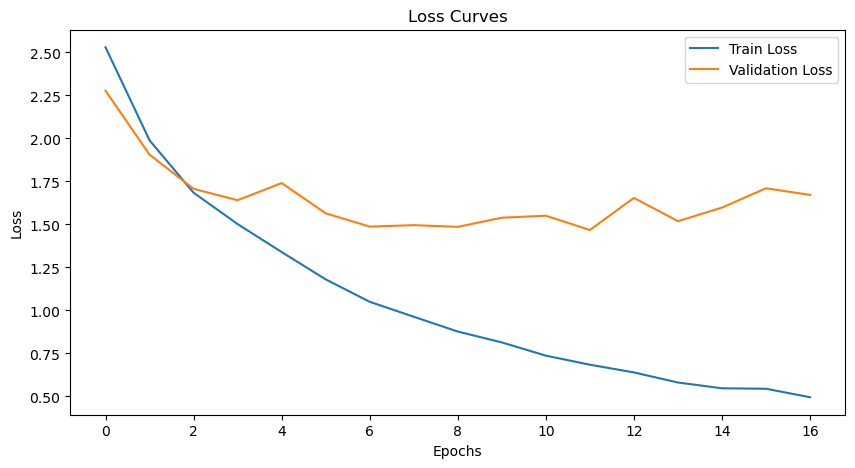

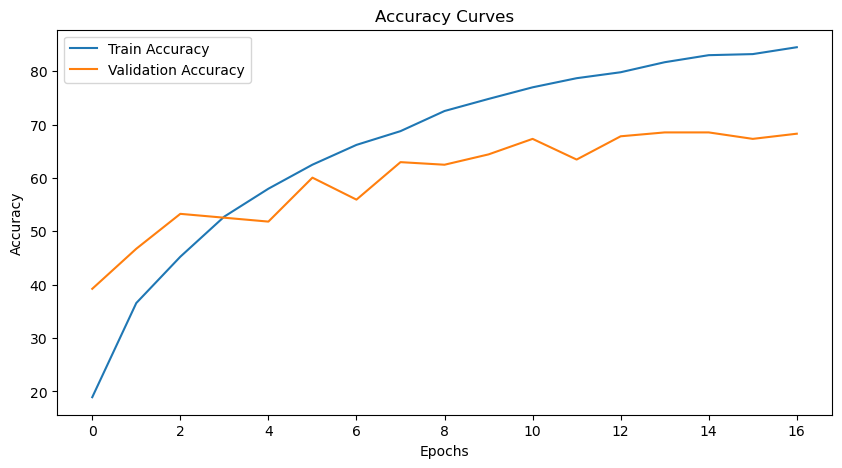

In [9]:
# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

#### Evaluation

In [10]:
model.load_state_dict(torch.load(best_model_path))
model.to(device)

# Set the model to evaluation mode
model.eval()

# Evaluate on the test set
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 72.30%


Previously, I trained a CNN with a similar architecture to the one described above, but it consisted of only two convolutional layers. That model achieved a test set accuracy of approximately 50%. Given the low training accuracy and overall poor performance, I hypothesized that the model was underfitting—likely due to insufficient representational capacity in the shallow architecture.

To test this hypothesis, I increased the network depth by adding an additional convolutional layer, resulting in a three-layer CNN. This deeper model significantly outperformed the previous one, achieving a test set accuracy of 72.3%. While this was a notable improvement, the training accuracy remained relatively low at 78.64% when the 'best model' was saved, indicating that the model still struggled to fit the training data fully.

These observations suggest that a deeper architecture might further improve performance by enabling the network to learn more complex and hierarchical features. Additionally, the absence of hyperparameter tuning, such as optimizing the learning rate, batch size, and regularization strategies, likely limits the model's full potential. Incorporating these techniques could further boost performance.

However, given the moderate dataset size and the challenges of training deeper architectures from scratch, a better approach might involve leveraging transfer learning. By using a pre-trained ResNet-18 model, we can capitalize on its ability to extract robust features from the images. Below, I demonstrate how to fine-tune a pre-trained ResNet-18 for classification on the Jute Pest dataset.

## Transfer Learning with Resnet18

In [11]:
# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Number of classes in your dataset
num_classes = len(train_data.classes)

# Modify the final fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

e:\anaconda3\envs\act_smile\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anaconda3\envs\act_smile\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Freeze all layers except the final layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model.fc.parameters():
    param.requires_grad = True

# Unfreeze the last residual block
for param in model.layer4.parameters():
    param.requires_grad = True

In [13]:
# Use CrossEntropyLoss for classification
criterion = nn.CrossEntropyLoss()

# Define optimizer with only trainable parameters
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Print trainable parameters to verify
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 8402449


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, delta=0.01)

# best model path to save
best_model_resnet18_path = 'best_resnet18_model.pth'

# Track metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training step
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation step
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print metrics for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Save the best model
    if early_stopping.best_loss is None or val_loss < early_stopping.best_loss - early_stopping.delta:
        torch.save(model.state_dict(), best_model_resnet18_path)
        print(f"Best model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}")

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

Epoch 1/10, Train Loss: 0.4197, Train Acc: 87.63%, Validation Loss: 0.5662, Val Acc: 86.68%
Best model saved at epoch 1 with validation loss: 0.5662
Epoch 2/10, Train Loss: 0.1603, Train Acc: 95.27%, Validation Loss: 0.5046, Val Acc: 86.44%
Best model saved at epoch 2 with validation loss: 0.5046
Epoch 3/10, Train Loss: 0.0925, Train Acc: 97.04%, Validation Loss: 0.6041, Val Acc: 87.65%
Epoch 4/10, Train Loss: 0.0934, Train Acc: 97.47%, Validation Loss: 0.6304, Val Acc: 87.89%
Epoch 5/10, Train Loss: 0.0669, Train Acc: 97.84%, Validation Loss: 0.5337, Val Acc: 87.89%
Epoch 6/10, Train Loss: 0.0431, Train Acc: 98.60%, Validation Loss: 0.5306, Val Acc: 88.38%
Epoch 7/10, Train Loss: 0.0499, Train Acc: 98.36%, Validation Loss: 0.6074, Val Acc: 88.14%
Early stopping triggered!


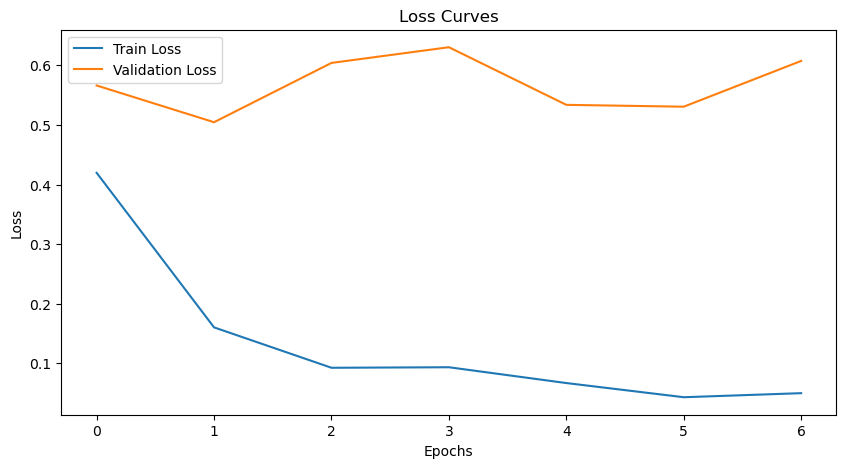

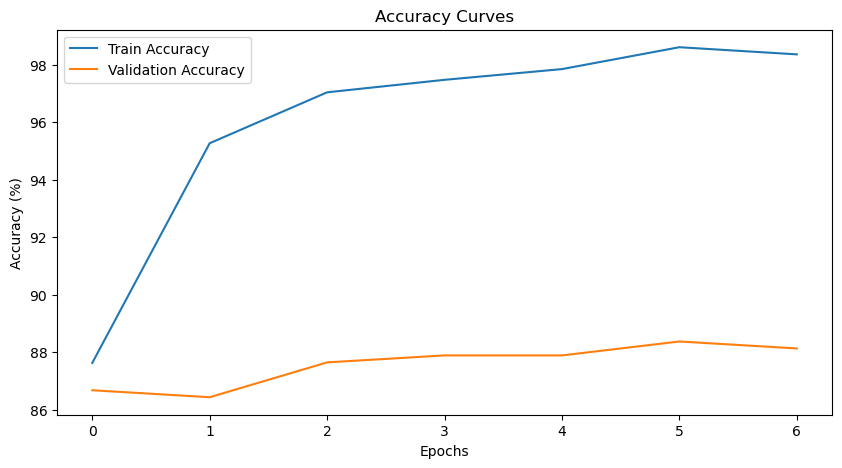

In [15]:
# Plot metrics after training
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

#### Evaluation

In [ ]:
# Load the best model
model.load_state_dict(torch.load(best_model_resnet18_path))
model.to(device)

# Initialize lists to store true and predicted labels
all_labels = []
all_probabilities = []
all_predictions = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        _, predicted = torch.max(outputs, 1)

        # Store true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Calculate accuracy
accuracy = 100 * np.trace(cm) / np.sum(cm)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 96.83%


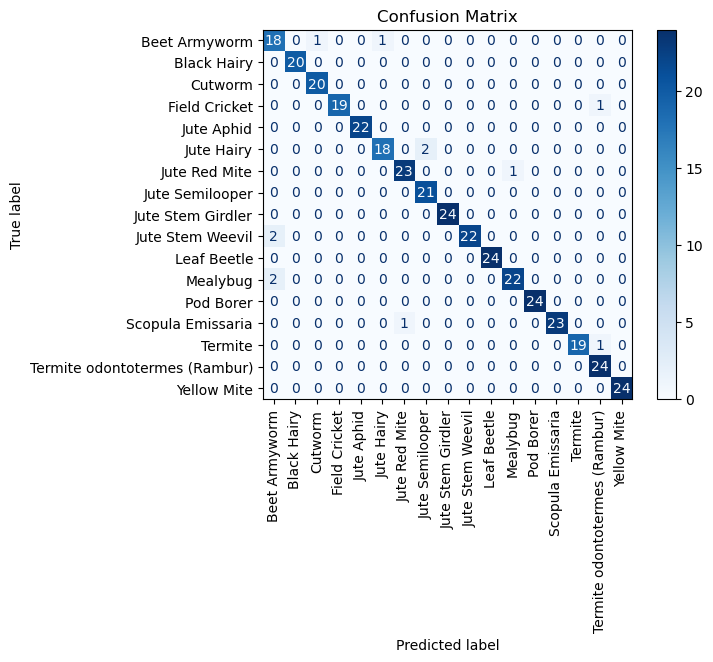

In [21]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_loader.dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

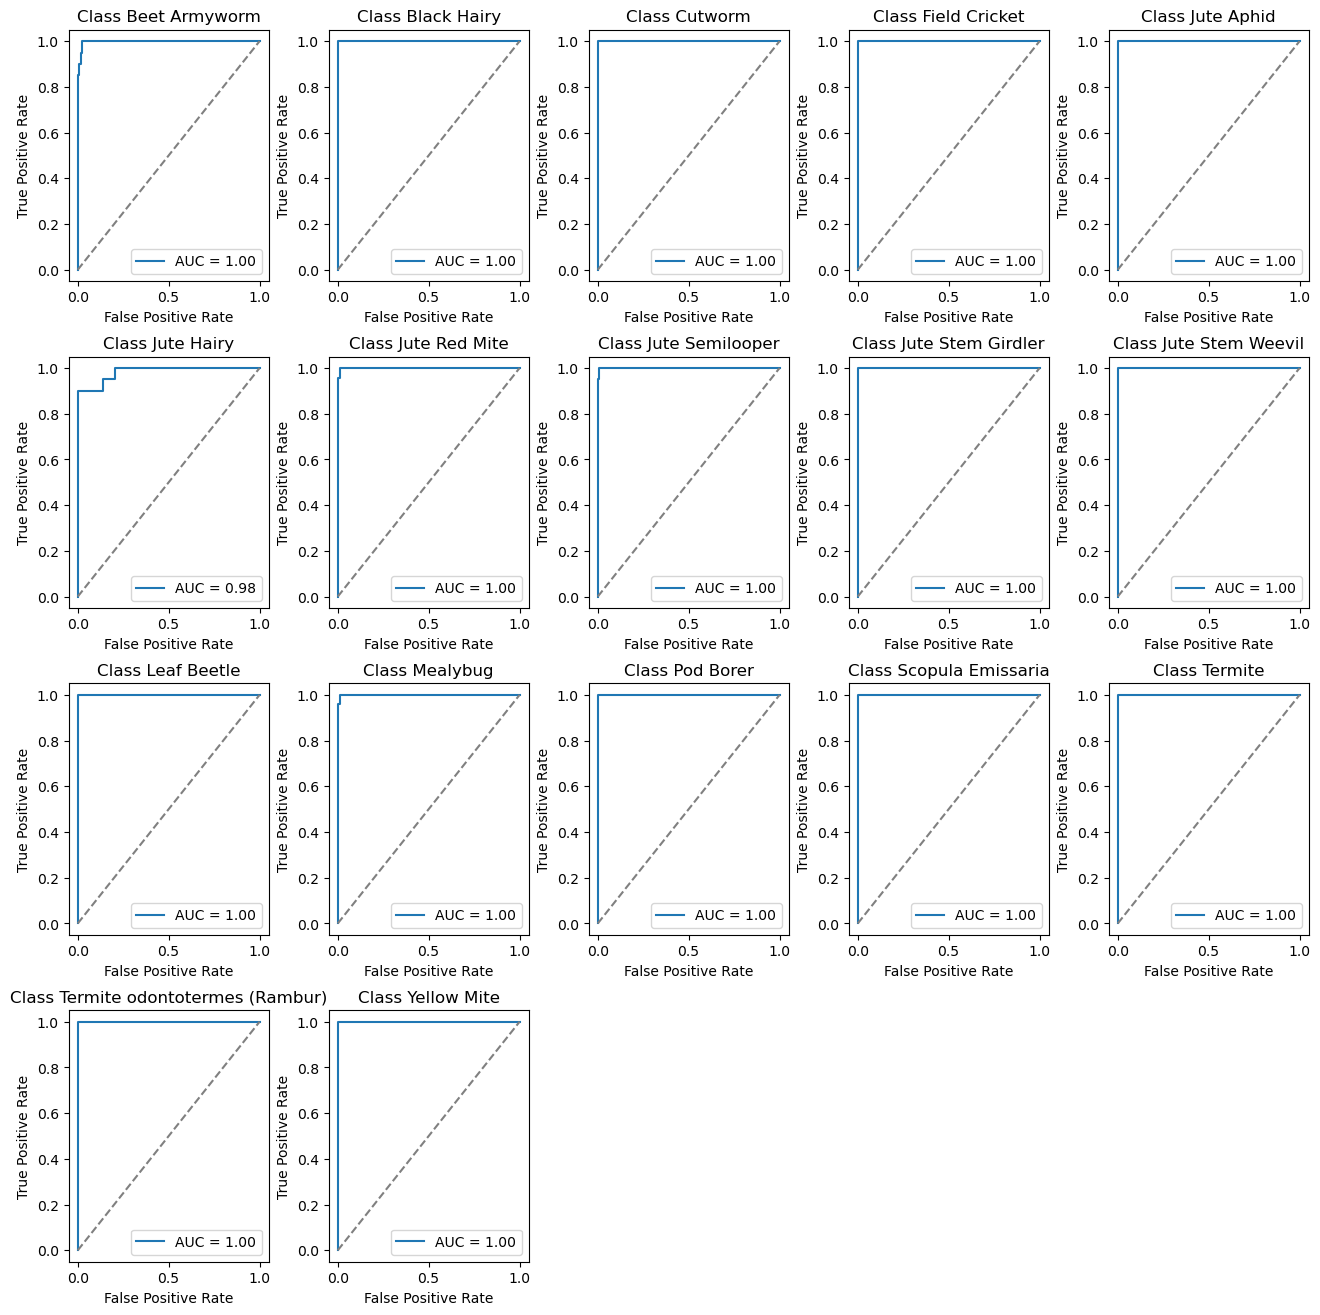

In [35]:
# Binarize the true labels for multi-class ROC curve
all_labels_bin = label_binarize(all_labels, classes=range(num_classes))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probabilities)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Set up a 4x4 grid for subplots
nrows, ncols = 4, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))  # Adjust figure size as needed
axes = axes.flatten()  # Flatten axes array for easy iteration

# Plot each class-specific ROC curve
for i in range(num_classes):
    ax = axes[i]
    ax.plot(fpr[i], tpr[i], label=f"AUC = {roc_auc[i]:.2f}")
    ax.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
    ax.set_title(f"Class {test_loader.dataset.classes[i]}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

# Turn off unused subplots
for i in range(num_classes, len(axes)):
    axes[i].axis("off")

# Adjust layout for better spacing
fig.subplots_adjust(hspace=.3, wspace=0.3)
plt.show()

The transfer learning approach using a pre-trained ResNet-18 model achieved impressive results on the Jute Pest dataset, with a training accuracy of 95.27% and a test accuracy of 96.83%, indicating strong generalization and minimal overfitting. The confusion matrix highlights excellent class-wise performance, with most classes showing near-perfect classification. Classes like "Yellow Mite" and "Pod Borer" were classified flawlessly, while minor misclassifications, such as "Jute Stem Weevil" occasionally being confused with "Beet Armyworm," suggest some overlapping features or visual similarities. Leveraging ResNet-18's pre-trained weights enabled robust feature extraction and classification, reducing the need for extensive dataset-specific training. While the model performs exceptionally well, future improvements could focus on addressing rare misclassifications through targeted data augmentation, exploring alternative architectures like ResNet-50 or EfficientNet for further refinement, and/or performing hyperparameter tuning using gridsearch or Bayesian optimization techniques.